# Lab 1: Markov Decision Processes - Problem 1


## Lab Instructions
All your answers should be written in this notebook.  You shouldn't need to write or modify any other files.

**You should execute every block of code to not miss any dependency.**


*This project was developed by Peter Chen, Rocky Duan, Pieter Abbeel for the Berkeley Deep RL Bootcamp, August 2017. Bootcamp website with slides and lecture videos: https://sites.google.com/view/deep-rl-bootcamp/. It is adapted from Berkeley Deep RL Class [HW2](https://github.com/berkeleydeeprlcourse/homework/blob/c1027d83cd542e67ebed982d44666e0d22a00141/hw2/HW2.ipynb) [(license)](https://github.com/berkeleydeeprlcourse/homework/blob/master/LICENSE)*

--------------------------

## Introduction

This assignment will review the two classic methods for solving Markov Decision Processes (MDPs) with finite state and action spaces.
We will implement value iteration (VI) and policy iteration (PI) for a finite MDP, both of which find the optimal policy in a finite number of iterations.

The experiments here will use the Frozen Lake environment, a simple gridworld MDP that is taken from `gym` and slightly modified for this assignment. In this MDP, the agent must navigate from the start state to the goal state on a 4x4 grid, with stochastic transitions.

In [1]:
from misc import FrozenLakeEnv, make_grader
env = FrozenLakeEnv()
print(env.__doc__)


    Winter is here. You and your friends were tossing around a frisbee at the park
    when you made a wild throw that left the frisbee out in the middle of the lake.
    The water is mostly frozen, but there are a few holes where the ice has melted.
    If you step into one of those holes, you'll fall into the freezing water.
    At this time, there's an international frisbee shortage, so it's absolutely imperative that
    you navigate across the lake and retrieve the disc.
    However, the ice is slippery, so you won't always move in the direction you intend.
    The surface is described using a grid like the following

        SFFF
        FHFH
        FFFH
        HFFG

    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located

    The episode ends when you reach the goal or fall in a hole.
    You receive a reward of 1 if you reach the goal, and zero otherwise.

    


Let's look at what a random episode looks like.

In [2]:
# Some basic imports and setup
import numpy as np, numpy.random as nr, gym
import matplotlib.pyplot as plt
%matplotlib inline
np.set_printoptions(precision=3)

# Seed RNGs so you get the same printouts as me
env.seed(0); from gym.spaces import prng; prng.seed(10)
# Generate the episode
env.reset()
for t in range(100):
    env.render()
    a = env.action_space.sample()
    ob, rew, done, _ = env.step(a)
    if done:
        break
assert done
env.render();


SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG


In the episode above, the agent falls into a hole after two timesteps. Also note the stochasticity--on the first step, the DOWN action is selected, but the agent moves to the right.

We extract the relevant information from the gym Env into the MDP class below.
The `env` object won't be used any further, we'll just use the `mdp` object.

In [3]:
class MDP(object):
    def __init__(self, P, nS, nA, desc=None):
        self.P = P # state transition and reward probabilities, explained below
        self.nS = nS # number of states
        self.nA = nA # number of actions
        self.desc = desc # 2D array specifying what each grid cell means (used for plotting)
mdp = MDP( {s : {a : [tup[:3] for tup in tups] for (a, tups) in a2d.items()} for (s, a2d) in env.P.items()}, env.nS, env.nA, env.desc)


print("mdp.P is a two-level dict where the first key is the state and the second key is the action.")
print("The 2D grid cells are associated with indices [0, 1, 2, ..., 15] from left to right and top to down, as in")
print(np.arange(16).reshape(4,4))
print("Action indices [0, 1, 2, 3] correspond to West, South, East and North.")
print("mdp.P[state][action] is a list of tuples (probability, nextstate, reward).\n")
print("For example, state 0 is the initial state, and the transition information for s=0, a=0 is \nP[0][0] =", mdp.P[0][0], "\n")
print("As another example, state 5 corresponds to a hole in the ice, in which all actions lead to the same state with probability 1 and reward 0.")
for i in range(4):
    print("P[5][%i] =" % i, mdp.P[5][i])

mdp.P is a two-level dict where the first key is the state and the second key is the action.
The 2D grid cells are associated with indices [0, 1, 2, ..., 15] from left to right and top to down, as in
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
Action indices [0, 1, 2, 3] correspond to West, South, East and North.
mdp.P[state][action] is a list of tuples (probability, nextstate, reward).

For example, state 0 is the initial state, and the transition information for s=0, a=0 is 
P[0][0] = [(0.1, 0, 0.0), (0.8, 0, 0.0), (0.1, 4, 0.0)] 

As another example, state 5 corresponds to a hole in the ice, in which all actions lead to the same state with probability 1 and reward 0.
P[5][0] = [(1.0, 5, 0)]
P[5][1] = [(1.0, 5, 0)]
P[5][2] = [(1.0, 5, 0)]
P[5][3] = [(1.0, 5, 0)]


## Part 1: Value Iteration

### Problem 1: implement value iteration
In this problem, you'll implement value iteration, which has the following pseudocode:

---
Initialize $V^{(0)}(s)=0$, for all $s$

For $i=0, 1, 2, \dots$
- $V^{(i+1)}(s) = \max_a \sum_{s'} P(s,a,s') [ R(s,a,s') + \gamma V^{(i)}(s')]$, for all $s$

---

We additionally define the sequence of greedy policies $\pi^{(0)}, \pi^{(1)}, \dots, \pi^{(n-1)}$, where
$$\pi^{(i)}(s) = \arg \max_a \sum_{s'} P(s,a,s') [ R(s,a,s') + \gamma V^{(i)}(s')]$$

Your code will return two lists: $[V^{(0)}, V^{(1)}, \dots, V^{(n)}]$ and $[\pi^{(0)}, \pi^{(1)}, \dots, \pi^{(n-1)}]$

To ensure that you get the same policies as the reference solution, choose the lower-index action to break ties in $\arg \max_a$. This is done automatically by np.argmax. This will only affect the "# chg actions" printout below--it won't affect the values computed.

<div class="alert alert-warning">
Warning: make a copy of your value function each iteration and use that copy for the update--don't update your value function in place. 
Updating in-place is also a valid algorithm, sometimes called Gauss-Seidel value iteration or asynchronous value iteration, but it will cause you to get different results than our reference solution (which in turn will mean that our testing code won’t be able to help in verifying your code).
</div>

In [21]:
def value_iteration(mdp, gamma, nIt, grade_print=print):
    """
    Inputs:
        mdp: MDP
        gamma: discount factor
        nIt: number of iterations, corresponding to n above
    Outputs:
        (value_functions, policies)
        
    len(value_functions) == nIt+1 and len(policies) == nIt
    """
    grade_print("Iteration | max|V-Vprev| | # chg actions | V[0]")
    grade_print("----------+--------------+---------------+---------")
    Vs = [np.zeros(mdp.nS)] # list of value functions contains the initial value function V^{(0)}, which is zero
    pis = []
    for it in range(nIt):
        oldpi = pis[-1] if len(pis) > 0 else None # \pi^{(it)} = Greedy[V^{(it-1)}]. Just used for printout
        Vprev = Vs[-1] # V^{(it)}
        
        # Your code should fill in meaningful values for the following two variables
        # pi: greedy policy for Vprev (not V), 
        #     corresponding to the math above: \pi^{(it)} = Greedy[V^{(it)}]
        #     ** it needs to be numpy array of ints **
        # V: bellman backup on Vprev
        #     corresponding to the math above: V^{(it+1)} = T[V^{(it)}]
        #     ** numpy array of floats **
        
        V = np.copy(Vprev)
        pi = np.zeros(mdp.nS)
        for s in range(mdp.nS):
            val, act = V[s], pi[s]
            for a in range(mdp.nA):
                a_val = np.sum([p*(r + gamma*Vprev[ns]) for p, ns, r in mdp.P[s][a]])
                if a_val > val:
                    val, act = a_val, a
            V[s], pi[s] = val, act
        
        max_diff = np.abs(V - Vprev).max()
        nChgActions="N/A" if oldpi is None else (pi != oldpi).sum()
        grade_print("%4i      | %6.5f      | %4s          | %5.3f"%(it, max_diff, nChgActions, V[0]))
        Vs.append(V)
        pis.append(pi)
    return Vs, pis

GAMMA = 0.95 # we'll be using this same value in subsequent problems


# The following is the output of a correct implementation; when
#   this code block is run, your implementation's print output will be
#   compared with expected output.
#   (incorrect line in red background with correct line printed side by side to help you debug)
expected_output = """Iteration | max|V-Vprev| | # chg actions | V[0]
----------+--------------+---------------+---------
   0      | 0.80000      |  N/A          | 0.000
   1      | 0.60800      |    2          | 0.000
   2      | 0.51984      |    2          | 0.000
   3      | 0.39508      |    2          | 0.000
   4      | 0.30026      |    2          | 0.000
   5      | 0.25355      |    1          | 0.254
   6      | 0.10478      |    0          | 0.345
   7      | 0.09657      |    0          | 0.442
   8      | 0.03656      |    0          | 0.478
   9      | 0.02772      |    0          | 0.506
  10      | 0.01111      |    0          | 0.517
  11      | 0.00735      |    0          | 0.524
  12      | 0.00310      |    0          | 0.527
  13      | 0.00190      |    0          | 0.529
  14      | 0.00083      |    0          | 0.530
  15      | 0.00049      |    0          | 0.531
  16      | 0.00022      |    0          | 0.531
  17      | 0.00013      |    0          | 0.531
  18      | 0.00006      |    0          | 0.531
  19      | 0.00003      |    0          | 0.531"""
Vs_VI, pis_VI = value_iteration(mdp, gamma=GAMMA, nIt=20, grade_print=make_grader(expected_output))

Iteration | max|V-Vprev| | # chg actions | V[0]
----------+--------------+---------------+---------
   0      | 0.80000      |  N/A          | 0.000
   1      | 0.60800      |    2          | 0.000
   2      | 0.51984      |    2          | 0.000
   3      | 0.39508      |    2          | 0.000
   4      | 0.30026      |    2          | 0.000
   5      | 0.25355      |    1          | 0.254
   6      | 0.10478      |    0          | 0.345
   7      | 0.09657      |    0          | 0.442
   8      | 0.03656      |    0          | 0.478
   9      | 0.02772      |    0          | 0.506
  10      | 0.01111      |    0          | 0.517
  11      | 0.00735      |    0          | 0.524
  12      | 0.00310      |    0          | 0.527
  13      | 0.00190      |    0          | 0.529
  14      | 0.00083      |    0          | 0.530
  15      | 0.00049      |    0          | 0.531
  16      | 0.00022      |    0          | 0.531
  17      | 0.00013      |    0          | 0.531
  18      | 0.0000

Below, we've illustrated the progress of value iteration. Your optimal actions are shown by arrows.
At the bottom, the value of the different states are plotted.

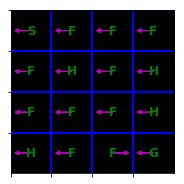

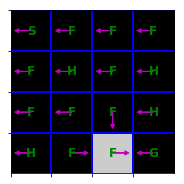

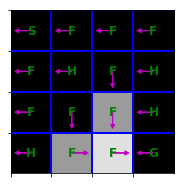

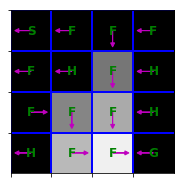

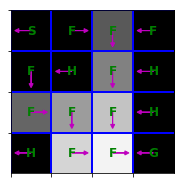

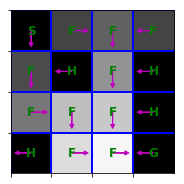

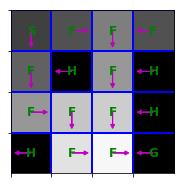

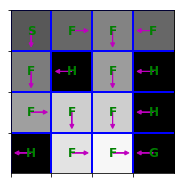

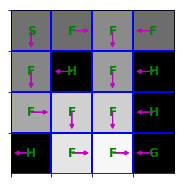

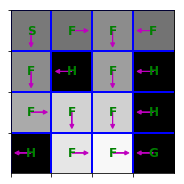

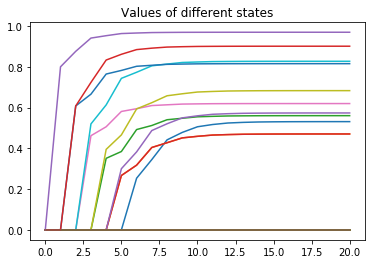

In [22]:
for (V, pi) in zip(Vs_VI[:10], pis_VI[:10]):
    plt.figure(figsize=(3,3))
    plt.imshow(V.reshape(4,4), cmap='gray', interpolation='none', clim=(0,1))
    ax = plt.gca()
    ax.set_xticks(np.arange(4)-.5)
    ax.set_yticks(np.arange(4)-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:4, 0:4]
    a2uv = {0: (-1, 0), 1:(0, -1), 2:(1,0), 3:(-1, 0)}
    Pi = pi.reshape(4,4)
    for y in range(4):
        for x in range(4):
            a = Pi[y, x]
            u, v = a2uv[a]
            plt.arrow(x, y,u*.3, -v*.3, color='m', head_width=0.1, head_length=0.1) 
            plt.text(x, y, str(env.desc[y,x].item().decode()),
                     color='g', size=12,  verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
    plt.grid(color='b', lw=2, ls='-')
plt.figure()
plt.plot(Vs_VI)
plt.title("Values of different states");